# Introduction

This notebook is dedicated to calculating and predicting the demand for hotel bookings using the "is_canceled" column as the target variable (or 'y'). The target column is a binary classification where 0 indicates a booking was not canceled and 1 indicates a booking was canceled. The primary goal is to build and evaluate models that can accurately predict whether a booking will be canceled based on various features in the dataset.

To achieve this, we will use two machine learning models that are based on tree algorithms:
1. **CatBoost Classifier**
2. **Random Forest Classifier**

Tree-based models are particularly well-suited for this type of classification problem due to their ability to handle complex relationships between features and their robustness to different types of data distributions. 

Using these machine learning models, the workflow will follow these steps:
- **Load Data:** Import the dataset and perform initial data inspection to understand its structure and contents.
- **Data Preprocessing:** Clean the data by handling missing values, encoding categorical variables, and normalizing numerical features where necessary.
- **Train-Test Split:** Divide the dataset into training and testing sets to evaluate model performance.
- **Smote Resample:** Resampling the train set data for handle the imbalances dataset.
- **Model Training:** Train the CatBoost and Random Forest models using the training data.
- **Model Evaluation:** Assess the performance of the trained models using various metrics.
- **Model Tuning:** Optimize model hyperparameters to improve accuracy and other performance metrics.
- **Features Importaces Permutation:** Conduct a features that was important and less important.
- **Final Evaluation:** Conduct a final evaluation of the tuned models on the test data.

For evaluating the performance of the models, the following metrics will be used:
- **Accuracy:** The proportion of correctly classified instances out of the total instances.
- **ROC-AUC:** A metric that evaluates the model's ability to distinguish between classes. 
- **F1 Score:** The harmonic mean of precision and recall, which provides a balance between the two.
- **Recall Score:** The ability of the model to correctly identify all relevant instances (i.e., correctly predicting cancellations).
- **Confusion Matrix:** A matrix that provides a detailed breakdown of the model's performance by showing the true positives, true negatives, false positives, and false negatives.


In [1]:
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
/opt/conda/bin/nvcc


In [2]:
!python --version
!nvidia-smi

Python 3.10.13
Fri Jul 26 07:58:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [3]:
# !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

# Importing Libraries

In [4]:
# importing libraries fundamentals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from matplotlib import pyplot

import plotly.express as px

# Library for Null Values Imputing
import missingno as msno

# Library for Encoding and Imputer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Library for Machine Learning Frameworks
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import joblib

# importing cudas

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hotel_bookings.csv


# Loading the Dataset

In [6]:
# load cudas extension

# %load_ext cudf.pandas

# import data from gdrive

df = pd.read_csv("/kaggle/input/hotel_bookings.csv")

## Dataset Information

In [7]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
df.describe()
# description of dataset

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [9]:
df.info()

# there by are 32 columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
df.shape
# Dataset has 119390 rows and 32 columns

(119390, 32)

In [11]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [12]:
cat_cols = df.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')


In [13]:
num_cols = df.select_dtypes(include=['float', 'int64']).columns
print(num_cols)

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')


In [14]:
df['is_canceled'].value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

## Dealt with Null Values



In [15]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

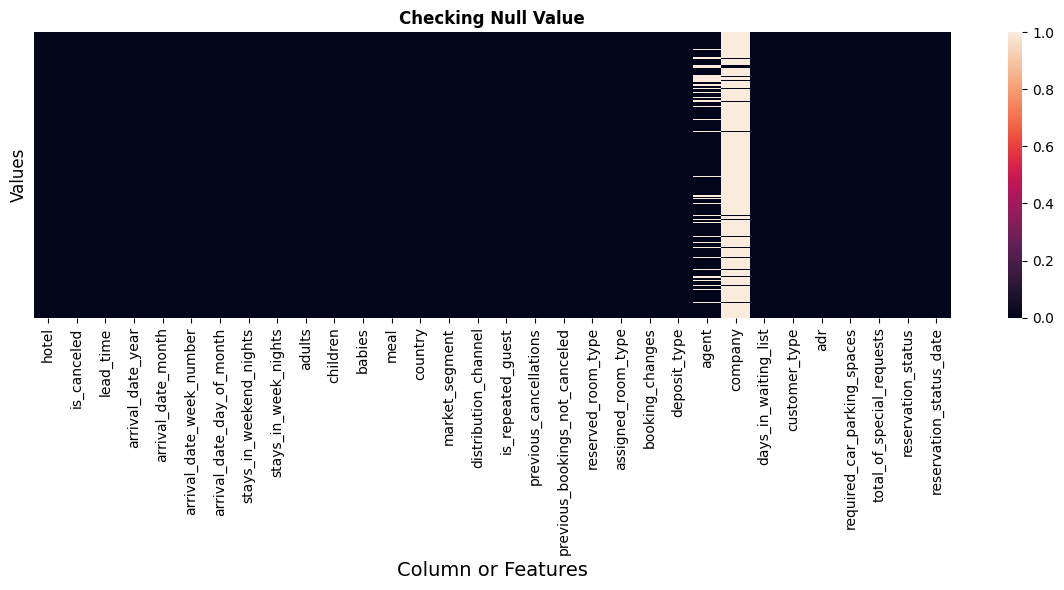

In [16]:
# Plotting Null Values using HeatMap

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), yticklabels=False)
plt.title('Checking Null Value', weight='bold')
plt.xlabel('Column or Features', fontsize=14)
plt.ylabel('Values', fontsize=12)
plt.tight_layout()

In [17]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   children  119386 non-null  float64
 1   country   118902 non-null  object 
 2   agent     103050 non-null  float64
 3   company   6797 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.6+ MB


from there we could see the most null values is company, so we will drop the feature or column 'company'

In [18]:
# dropping company column, i used to drop it cause the data was so many values null
df = df.drop(['company'], axis=1)

In [19]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   children  119386 non-null  float64
 1   country   118902 non-null  object 
 2   agent     103050 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.7+ MB


In [20]:
def fill_categorical(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def fill_numerical(df):
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

# Fill missing values
df = fill_categorical(df)
df = fill_numerical(df)

In [21]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Empty DataFrame


theres no null value again :)

# Pearson Feature Elimination

In [22]:
df_corr = df.copy()
df_corr = df_corr.drop(['is_canceled'], axis=1)

In [23]:
def labelencode(df_corr):
    le = LabelEncoder()
    cat_cols = df_corr.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df_corr[col] = le.fit_transform(df_corr[col])
    return df_corr

df_corr = labelencode(df_corr)

In [24]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_year               119390 non-null  int64  
 3   arrival_date_month              119390 non-null  int64  
 4   arrival_date_week_number        119390 non-null  int64  
 5   arrival_date_day_of_month       119390 non-null  int64  
 6   stays_in_weekend_nights         119390 non-null  int64  
 7   stays_in_week_nights            119390 non-null  int64  
 8   adults                          119390 non-null  int64  
 9   children                        119390 non-null  float64
 10  babies                          119390 non-null  int64  
 11  meal                            119390 non-null  int64  
 12  country         

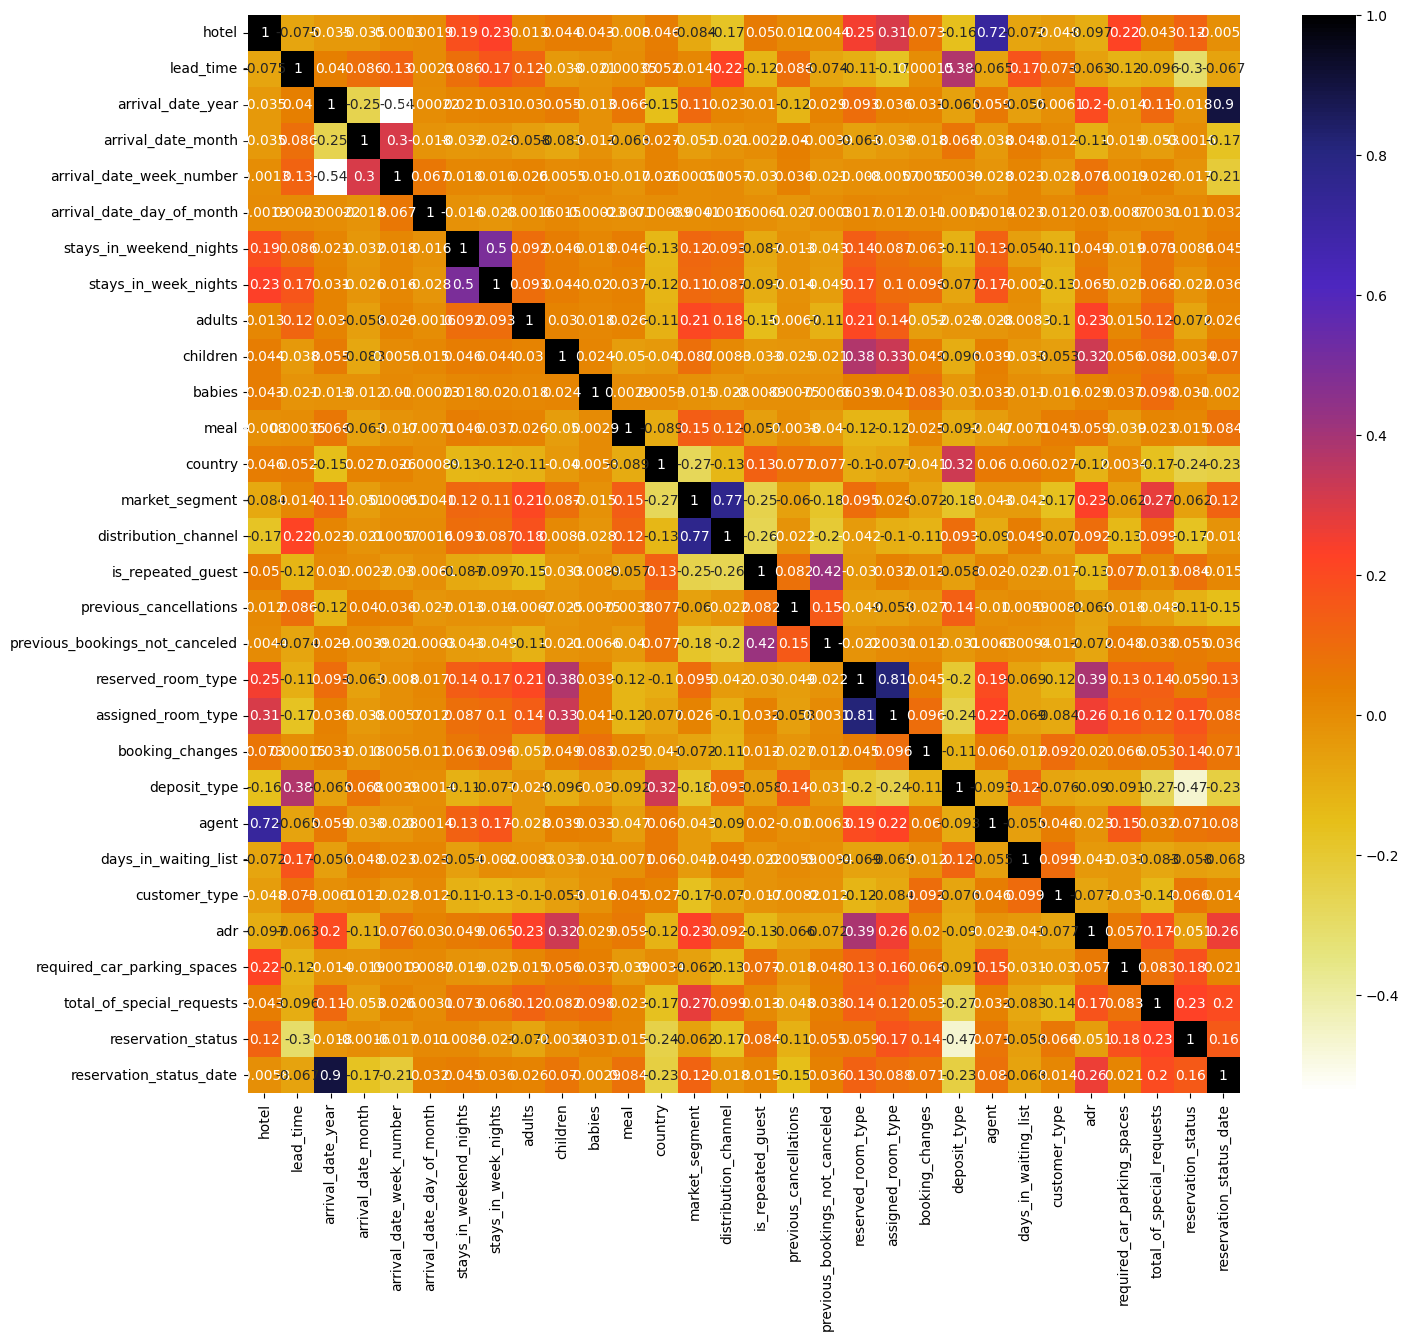

In [25]:
plt.figure(figsize=(16,14))
cor = df_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [26]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr      

corr_features = correlation(df_corr, 0.7)
print(f"Feature should be erased has: {len(set(corr_features))}")
print(f"therefore column should be erased is {corr_features}")
df = df.drop(columns=corr_features)
df.info()

Feature should be erased has: 4
therefore column should be erased is {'reservation_status_date', 'agent', 'distribution_channel', 'assigned_room_type'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  i

In [27]:
# Drop Features less important
df = df.drop(['reservation_status','stays_in_weekend_nights','arrival_date_year','arrival_date_week_number',
              'stays_in_weekend_nights','arrival_date_day_of_month','meal','babies','children'], axis=1)
print(df.shape)

(119390, 19)


Drop some features again for Model Fit

# Train Test Split Data and OneHotEncoding

In [28]:
categorical_columns = df.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')


In [29]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [30]:
def one_hot_encode_categorical(X, categorical_columns):
    # Instantiate the OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_array = encoder.fit_transform(X[categorical_columns])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))
    X = X.drop(columns=categorical_columns)
    X = pd.concat([X, encoded_df], axis=1)

    return X

X_encoded = one_hot_encode_categorical(X, categorical_columns)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(95512, 220) (95512,)
(23878, 220) (23878,)


# Resampling Data

<Axes: xlabel='is_canceled', ylabel='count'>

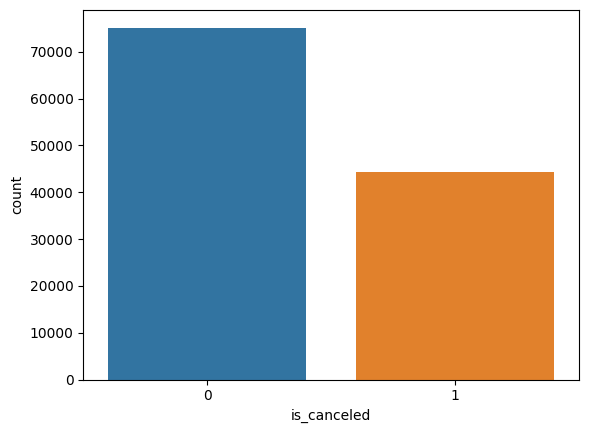

In [33]:
sns.countplot(x='is_canceled',data=df)

<Axes: xlabel='is_canceled', ylabel='count'>

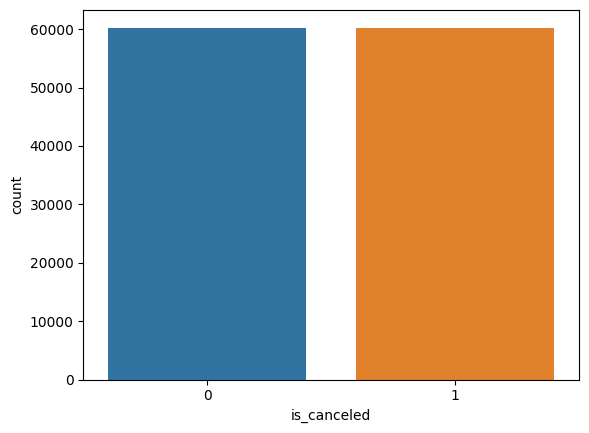

In [34]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)
sns.countplot(x=y_train,data=df)

## CatBoost Classifier Model

In [35]:
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=False)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

roc_auc_cat = roc_auc_score(y_test, cat_pred)
print(f"ROC AUC score: {roc_auc_cat:.2f}")
print(classification_report(y_test, cat_pred))

ROC AUC score: 0.85
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     14907
           1       0.84      0.80      0.82      8971

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.86     23878
weighted avg       0.87      0.87      0.87     23878



In [36]:
catboost_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 8]
}


grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=catboost_param_grid, 
                           cv=3, n_jobs=-1, scoring='accuracy')

grid_search_cat.fit(X_train, y_train)
best_params_cat = grid_search_cat.best_params_
best_score_cat = grid_search_cat.best_score_

# Print the results
print(f"Best Parameters: {best_params_cat}")
print(f"Best Cross-Validation Score: {best_score_cat:.4f}")

Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.5}
Best Cross-Validation Score: 0.8775


In [37]:
best_model_cat = grid_search_cat.best_estimator_
best_model_cat.fit(X_train, y_train)
best_pred_cat = best_model_cat.predict(X_test)

roc_auc_cat_best = roc_auc_score(y_test, best_pred_cat)
print(f"ROC AUC score: {roc_auc_cat_best:.2f}")
print(classification_report(y_test, best_pred_cat))

ROC AUC score: 0.85
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     14907
           1       0.84      0.80      0.82      8971

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.86     23878
weighted avg       0.87      0.87      0.87     23878



## Random Forest Classifier Model

In [38]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

roc_auc_rf = roc_auc_score(y_test, rf_pred)
print(f"ROC AUC score: {roc_auc_rf:.2f}")
print(classification_report(y_test, rf_pred))

ROC AUC score: 0.86
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     14907
           1       0.87      0.80      0.83      8971

    accuracy                           0.88     23878
   macro avg       0.88      0.86      0.87     23878
weighted avg       0.88      0.88      0.88     23878



In [39]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, 
                                    cv=5, n_iter=10, random_state=42)

# Fit GridSearchCV
random_search_rf.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_

# Print the results
print(f"Best Parameters: {best_params_rf}")
print(f"Best Cross-Validation Score: {best_score_rf:.4f}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Best Cross-Validation Score: 0.8865


In [40]:
best_model_rf = random_search_rf.best_estimator_
best_model_rf.fit(X_train, y_train)
best_pred_rf = best_model_rf.predict(X_test)

roc_auc_rf_best = roc_auc_score(y_test, best_pred_rf)
print(f"ROC AUC score: {roc_auc_rf_best:.2f}")
print(classification_report(y_test, best_pred_rf))

ROC AUC score: 0.86
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     14907
           1       0.87      0.78      0.82      8971

    accuracy                           0.87     23878
   macro avg       0.87      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878



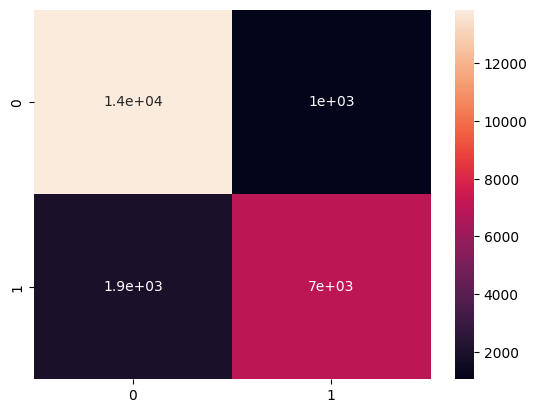

In [42]:
cm = confusion_matrix(y_test, best_pred_rf)
sns.heatmap(cm, annot=True);

## Permutation Feature Importance

this one for in future wants to drop some feature again

In [43]:
feature = pd.Series(best_model_rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
print(feature)

deposit_type_Non Refund      0.114985
lead_time                    0.111801
country_PRT                  0.103391
total_of_special_requests    0.086613
adr                          0.053889
                               ...   
country_BHS                  0.000000
country_ASM                  0.000000
country_ATA                  0.000000
country_ATF                  0.000000
country_AIA                  0.000000
Length: 220, dtype: float64


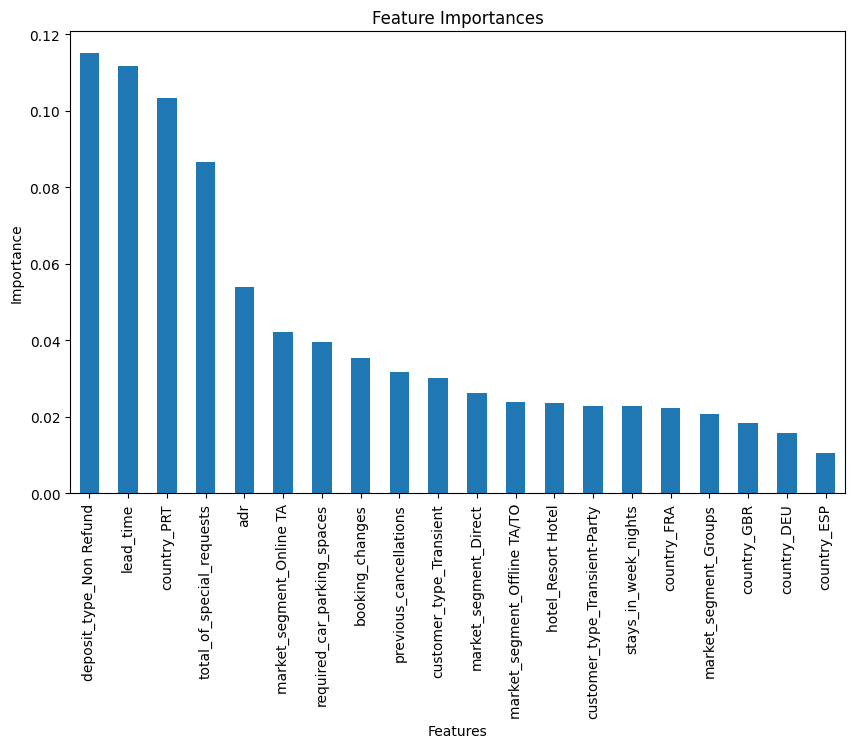

In [44]:
plt.figure(figsize=(10, 6))
feature.head(20).plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Model Chooses

In [45]:
joblib.dump(best_model_rf, 'random_forest_model.pkl')
loaded_model = joblib.load('random_forest_model.pkl')

# Conclusion :

I think the model is good, from metrics, the values we got was:

**1. Catboost Classifier**
- **Accuracy: 0.87**
- **ROC-AUC: 0.85**

**2. Random Forrest Classifier**
- **Accuracy: 0.87**
- **ROC-AUC: 0.86**

Therefore, i take Random Forrest Classifier Model, because of the good values that got.
